In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import math
from itertools import chain
import itertools
import random
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd.function import Function
import torch.nn.utils.prune as prune
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn, einsum
import logging
from functools import partial
from collections import OrderedDict
import seaborn as sns
import matplotlib as mp
import time
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
!gpustat
!nvidia-smi
!free
torch.cuda.is_available()

In [3]:
dat = pd.read_csv('xxx')
dat = dat.drop(dat.columns[[0]], axis=1)
dat = dat.T
feature_num = dat.shape[1]
data_num = dat.shape[0]
dat = dat.values.reshape(-1,1,feature_num)
print(dat.shape)

(638, 1, 11327)


In [4]:
class nolabel_set(torch.utils.data.Dataset):
    def __init__(self, data ,transform = None):
        self.transform = transform

        self.data = data
        self.datanum = len(data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data = torch.tensor(self.data[idx]).float()
        
        if self.transform:
            out_data = self.transform(out_data)

        return out_data

In [5]:
train_data_set = nolabel_set(data = dat)
train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = 256, shuffle=True)
print('data num:',len(dat))

data num: 638


In [6]:
RIM_cluster_num = 20

In [7]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost
        
        self.to_cls = nn.Sequential(
            #Set cluster number
            nn.Linear(embedding_dim, RIM_cluster_num), 
            nn.Sigmoid()
        )
        
    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = rearrange(inputs, 'b c l -> b l c')
        inputs = inputs.contiguous()
        #inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize
        quantized = torch.matmul(encodings, self._embedding.weight)
        
        #Norm(0,1)
#         quantized = quantized.view(quantized.size(0), -1)
#         quantized -= quantized.min(1, keepdim=True)[0]
#         quantized /= quantized.max(1, keepdim=True)[0]     
        
        #Get cls 
        cls = self.to_cls(quantized)
        
        #Unflatten
        quantized = quantized.view(input_shape)
               
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        quantized = rearrange(quantized, 'b c l -> b l c')
        quantized = quantized.contiguous()
                
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        #return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings
        return loss, quantized, perplexity, encodings, cls
    
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = rearrange(inputs, 'b c l -> b l c')
        inputs = inputs.contiguous()
        #inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
                         
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        quantized = rearrange(quantized, 'b c l -> b l c')
        quantized = quantized.contiguous()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
                       
        # convert quantized from BHWC -> BCHW
        #return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings
        return loss, quantized, perplexity, encodings   

In [8]:
class ResidualStack(nn.Module):
    def __init__(self, encoder_dim):
        super(ResidualStack, self).__init__()
        
        self.block = nn.Sequential(
            nn.Linear(encoder_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, encoder_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        return x + self.block(x)
    
class Encoder(nn.Module):
    def __init__(self, input_size, encoder_dim, dropout):
        super(Encoder, self).__init__()

        self.lay1 = nn.Sequential(
            nn.Linear(input_size, 2048),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.lay2 = nn.Sequential(
            nn.Linear(2048, encoder_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self._residual_stack = ResidualStack(encoder_dim)

    def forward(self, inputs):
        x = self.lay1(inputs)
        x = self.lay2(x)        
        x = self._residual_stack(x)
        return x 

class Decoder(nn.Module):
    def __init__(self, num_embeddings, input_size, encoder_dim, dropout):
        super(Decoder, self).__init__()
        
        self.lay0 = nn.Sequential(
            nn.Linear(num_embeddings, encoder_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self._residual_stack = ResidualStack(encoder_dim)
        
        self.lay1 = nn.Sequential(
            nn.Linear(encoder_dim, 2048),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self.lay2 = nn.Sequential(
            nn.Linear(2048, input_size),
            nn.GELU(),
            nn.Dropout(dropout)
        )

    def forward(self, inputs):
        x = self.lay0(inputs)
        x = self._residual_stack(x)
        x = self.lay1(x)
        x = self.lay2(x)
        
        return x

In [9]:
class Model(nn.Module):
    def __init__(self, input_size, encoder_dim, num_embeddings, embedding_dim, commitment_cost, dropout, decay=0):
        super(Model, self).__init__()
        
        self._encoder = Encoder(input_size, encoder_dim, dropout)
        
        self._pre_vq_conv = nn.Linear(encoder_dim, num_embeddings)
        
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
            
        self._decoder = Decoder(num_embeddings, input_size, encoder_dim, dropout)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, encodings, cls = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity, quantized, cls
    
    #quantized,cls

In [10]:
#RIM
def get_entropy_1D(xx):
    return( -torch.sum(xx * torch.log(xx + 1e-8)) )
def get_entropy_2D(xx):
    return( -torch.sum(xx * torch.log(xx + 1e-8), dim=1) )

In [11]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

out_dim = 512   
VQ_VAE = Model(
            dropout = 0.0,
            input_size = feature_num, 
            encoder_dim = out_dim,
            num_embeddings = 64,  
            embedding_dim = 64,   
            commitment_cost = 1
           ).to(DEVICE)

optimizer = optim.Adam(VQ_VAE.parameters(), lr=1e-5, amsgrad=False)
data_variance = np.var(dat)


cuda:0


<All keys matched successfully>

In [220]:
EPOCH = 200
train_res_recon_error = []
train_res_perplexity = []

VQ_VAE.train()

get_Marg_code_list=list()
get_Cond_code_list=list()

for epoch in tqdm.tqdm(range(EPOCH)):
    running_loss = 0.0
    count=0
    quantized_merge = torch.empty(0,1,64).to(DEVICE)
    for _, inputs in enumerate(train_dataloader, 0):
        
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        
#         #pruning
#         for i in range(len(parameters_to_prune)):
#             prune.random_unstructured(parameters_to_prune[i], 'weight', amount=0.5)
#             prune.remove(parameters_to_prune[i], 'weight')
        
        #loss, x_recon, perplexity, quantized, cls       
        vq_loss, data_recon, perplexity, quantized, cls = VQ_VAE(inputs)
        recon_error = F.mse_loss(data_recon, inputs) / data_variance
#         print('recon_error:',recon_error)
#         print('vq_loss:',vq_loss)
        
        codesof = torch.nn.functional.softmax(cls.reshape(len(cls), -1), dim = 1)
        codemean = torch.mean(codesof, dim = 0, keepdim = True)
        
        Marg_code = get_entropy_1D(codemean)
        Cond_code = torch.mean(get_entropy_2D(codesof))
        
        get_Marg_code=Marg_code.to('cpu')
        get_Marg_code=get_Marg_code.tolist()
        get_Marg_code_list.append(get_Marg_code)
        get_Cond_code=Cond_code.to('cpu')
        get_Cond_code=get_Cond_code.tolist()
        get_Cond_code_list.append(get_Cond_code)
        
        loss = recon_error + vq_loss + Marg_code - Cond_code
        loss.backward()
        optimizer.step()

        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())

    if (epoch+1) % 10 == 0:
        print('%d iterations' % (epoch+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

  6%|▌         | 12/200 [00:01<00:16, 11.31it/s]

10 iterations
recon_error: 0.885
perplexity: 8.872



 11%|█         | 22/200 [00:01<00:15, 11.33it/s]

20 iterations
recon_error: 0.888
perplexity: 9.106



 16%|█▌        | 32/200 [00:02<00:14, 11.23it/s]

30 iterations
recon_error: 0.891
perplexity: 9.195



 21%|██        | 42/200 [00:03<00:13, 11.48it/s]

40 iterations
recon_error: 0.894
perplexity: 9.399



 26%|██▌       | 52/200 [00:04<00:12, 11.40it/s]

50 iterations
recon_error: 0.893
perplexity: 9.513



 31%|███       | 62/200 [00:05<00:12, 11.29it/s]

60 iterations
recon_error: 0.889
perplexity: 9.612



 36%|███▌      | 72/200 [00:06<00:11, 11.47it/s]

70 iterations
recon_error: 0.884
perplexity: 9.704



 41%|████      | 82/200 [00:07<00:10, 11.27it/s]

80 iterations
recon_error: 0.878
perplexity: 9.735



 46%|████▌     | 92/200 [00:08<00:09, 11.52it/s]

90 iterations
recon_error: 0.874
perplexity: 9.779



 51%|█████     | 102/200 [00:08<00:08, 11.16it/s]

100 iterations
recon_error: 0.871
perplexity: 9.774



 56%|█████▌    | 112/200 [00:09<00:07, 11.32it/s]

110 iterations
recon_error: 0.869
perplexity: 9.840



 61%|██████    | 122/200 [00:10<00:06, 11.16it/s]

120 iterations
recon_error: 0.866
perplexity: 9.846



 66%|██████▌   | 132/200 [00:11<00:06, 11.15it/s]

130 iterations
recon_error: 0.865
perplexity: 9.916



 71%|███████   | 142/200 [00:12<00:05, 11.32it/s]

140 iterations
recon_error: 0.862
perplexity: 9.990



 76%|███████▌  | 152/200 [00:13<00:04, 11.60it/s]

150 iterations
recon_error: 0.860
perplexity: 10.109



 81%|████████  | 162/200 [00:14<00:03, 11.08it/s]

160 iterations
recon_error: 0.859
perplexity: 10.206



 86%|████████▌ | 172/200 [00:15<00:02, 11.60it/s]

170 iterations
recon_error: 0.858
perplexity: 10.247



 91%|█████████ | 182/200 [00:16<00:01, 11.48it/s]

180 iterations
recon_error: 0.857
perplexity: 10.205



 96%|█████████▌| 192/200 [00:16<00:00, 11.48it/s]

190 iterations
recon_error: 0.856
perplexity: 10.127



100%|██████████| 200/200 [00:17<00:00, 11.36it/s]

200 iterations
recon_error: 0.856
perplexity: 10.065



In [221]:
print(np.mean(get_Marg_code_list))
print(np.mean(get_Cond_code_list))

1.609420039455096
1.6094090449810028


In [ ]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2) 
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity)')
ax.set_xlabel('iteration')

In [224]:
NMSE_list = pd.DataFrame(train_res_recon_error_smooth)
ACU_list = pd.DataFrame(train_res_perplexity_smooth)

# unlabeled-data clustring test

In [12]:
en_lat = []
en_quantized = []
cls_list = []

for i in range(len(dat)):
    en_data = train_dataloader.dataset[i][0]
    latent_1 = VQ_VAE._encoder(en_data.view(1, 1, feature_num).float().to(DEVICE))
    _, _, _, latent_2, cls = VQ_VAE(en_data.view(1, 1, feature_num).float().to(DEVICE))
    en_lat.append(latent_1.cpu().detach().numpy())
    en_quantized.append(latent_2.cpu().detach().numpy())
    cls_list.append(cls.cpu().detach().numpy())
encode_out = np.array(en_lat)
encode_out = encode_out.reshape(len(dat), -1)
quantized_out = np.array(en_quantized)
quantized_out = quantized_out.reshape(len(dat), -1)
cls_list_out = np.array(cls_list)
cls_list_out = cls_list_out.reshape(len(dat), -1)
save_cls = cls_list_out
cls = np.argmax((cls_list_out == cls_list_out.max(axis=1)[:,None]).astype(int),axis=1)
print('encode_out:', encode_out.shape)
print('quantized_out:', quantized_out.shape)
print('cls_out:', cls_list_out.shape)
print('cls:', cls.shape)

encode_out: (638, 512)
quantized_out: (638, 64)
cls_out: (638, 5)
cls: (638,)


In [14]:
cluster_result = pd.DataFrame(cls, columns=['cluster'])
print(cluster_result.apply(pd.value_counts))
cluster_result

   cluster
2      249
0      151
4      122
3       93
1       23


,cluster
0,2
1,2
2,3
3,2
4,2
...,...
633,2
634,2
635,2
636,2


In [ ]:
latent_Z = encode_out

tsne = TSNE(early_exaggeration=50,
              learning_rate=500, 
              perplexity=10, 
              min_grad_norm=1e-7, 
              n_iter=1000,
              n_components=2).fit_transform(latent_Z)
x_min, x_max = np.min(tsne, 0), np.max(tsne, 0)
tsne = tsne / (x_max - x_min)
print('TSNE_out:', tsne.shape)

In [16]:
True_labels = pd.read_csv('label.csv', header=0)
TSNE_result = pd.DataFrame(tsne, columns=['TSNE_Dim1', 'TSNE_Dim2'])
TSNE_result['Subtype'] = True_labels
Subtype = TSNE_result.pop("Subtype")
TSNE_result

,TSNE_Dim1,TSNE_Dim2
0,0.173272,0.211769
1,-0.201734,0.124717
2,-0.579486,0.134502
3,0.037223,0.198435
4,0.092690,0.193654
...,...,...
633,0.048091,0.238473
634,0.283746,0.148078
635,0.108748,0.156376
636,0.008557,0.197228


In [ ]:
plt.figure(figsize=(10,10))

sbt_5 = ['#67875A','#E3E4DC','#A51D1F','#34090C','#C15C81']
sbt_4 = ['#e53935','#8e24aa','#039be5','#fdd835']
sbt_3 = ['#e53935','#8e24aa','#039be5']

lut = dict(zip(Subtype.unique(), sbt_5))
row_colors = Subtype.map(lut)

#normlize(0,1)
x_min, x_max = np.min(quantized_out, 0), np.max(quantized_out, 0)
quantized_out = quantized_out / (x_max - x_min)

sns.clustermap(pd.DataFrame(quantized_out), row_colors=row_colors,cmap="mako")
handles = [Patch(facecolor=lut[name]) for name in lut]
L = plt.legend(handles, lut, 
           title='Subtype',
           loc = (0.9,0.1),
           title_fontsize = 15, fontsize = 12, borderaxespad = 1,
           bbox_transform=plt.gcf().transFigure,
           frameon=False)
# L.get_texts()[0].set_text('Basal-like')
# L.get_texts()[1].set_text('HER2-enriched')
# L.get_texts()[2].set_text('Luminal A')
# L.get_texts()[3].set_text('Luminal B')
# L.get_texts()[4].set_text('Normal-like')


In [25]:
True_labels = pd.read_csv('BRCA-label_num_5.csv', header=0)
TSNE_result = pd.DataFrame(tsne, columns=['TSNE_Dim1', 'TSNE_Dim2'])
TSNE_result['Subtype'] = True_labels
#TSNE_result['Subtype'] = cluster_result['cluster']

[0.52072674 0.1463044 ]
[312.34805  87.75792]
pca_result: (638, 2)


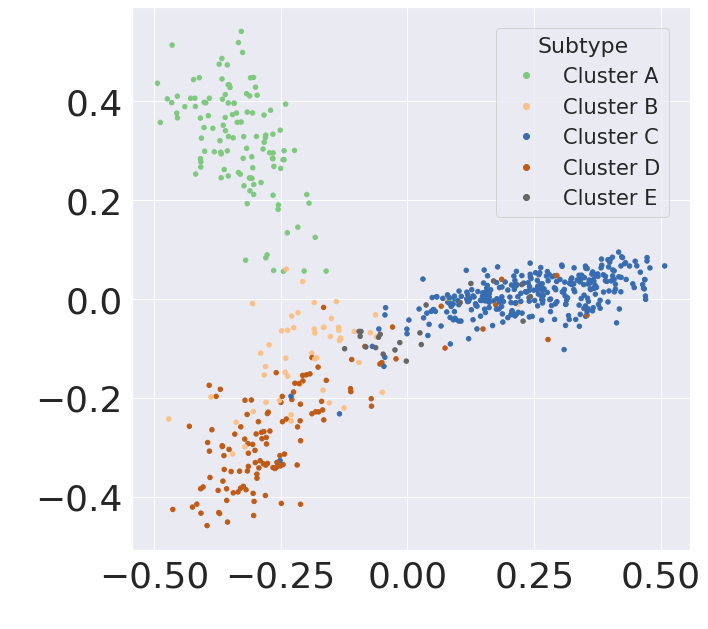

In [26]:
#change cluster color
ones = cluster_result == 4
zeros = cluster_result == 0
cluster_result[ones] = 0
cluster_result[zeros] = 4


#PCA of learened feature
pca = PCA(n_components=2)
pca.fit(latent_Z)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)
pca_result = pca.transform(latent_Z)
#normlize(0,1)
x_min, x_max = np.min(pca_result, 0), np.max(pca_result, 0)
pca_result = pca_result / (x_max - x_min)

print('pca_result:',pca_result.shape)
sns.set(style='darkgrid',context='notebook')
plt.figure(figsize=(10, 10)) 
a = plt.scatter(pca_result[:, 0], pca_result[:, 1], marker='o', c=TSNE_result['Subtype'],cmap='Accent',s=20)
L = plt.legend(*a.legend_elements(),
           borderaxespad = 1,
           title_fontsize = 22,
           fontsize = 21,
           loc="upper right", 
           title="Subtype")

#IDH mut-codel IDH mut-noncodel IDH wild-type
#Differentiated Immunoreactive Mesenchymal Proliferative


L.get_texts()[0].set_text('Cluster A')
L.get_texts()[1].set_text('Cluster B')
L.get_texts()[2].set_text('Cluster C')
L.get_texts()[3].set_text('Cluster D')
L.get_texts()[4].set_text('Cluster E')

plt.xlabel(" ", size=24)  
plt.ylabel(" ", size=24)
plt.tick_params(axis='x', which='both', labelsize=36)
plt.tick_params(axis='y', which='both', labelsize=36)
